In [1]:
!pip install python-bitcoinlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.0/107.0 kB 3.1 MB/s eta 0:00:00


In [2]:
import os
from bitcoin import *
from bitcoin.wallet import CBitcoinSecret, P2SHBitcoinAddress
from bitcoin.core import COIN, CMutableTransaction, CMutableTxOut, CMutableTxIn, CScript, COutPoint, lx, Hash160
from bitcoin.core.script import CScript, OP_2, OP_CHECKMULTISIG, OP_HASH160, OP_EQUAL, OP_0, SIGHASH_ALL, SignatureHash
import requests

In [3]:
#Tạo khoá riêng, khoá công khai, Redeem Script, địa chỉ P2SH
def generate_keypair():
  # Chọn tham số cho Testnet
  bitcoin.SelectParams('testnet')

  # Tạo ngẫu nhiên 2 khoá riêng
  private_key1 = CBitcoinSecret.from_secret_bytes(os.urandom(32))
  private_key2 = CBitcoinSecret.from_secret_bytes(os.urandom(32))

  # Tạo 2 khoá công khai từ 2 khoá riêng tư
  public_key1 = private_key1.pub
  public_key2 = private_key2.pub

  # Tạo Redeem Script (2-of-2 multisig)
  redeem_script = CScript([OP_2, public_key1, public_key2, OP_2, OP_CHECKMULTISIG])

  # Tạo địa chỉ P2SH từ Redeem Script
  address = P2SHBitcoinAddress.from_redeemScript(redeem_script)

  return private_key1, private_key2, redeem_script, address


In [5]:
#Khoá quỹ testnet BTC đã nhận từ Bitcoin Faucet
def scriptPubKey(redeem_script):
    redeem_script_hash = Hash160(redeem_script)
    script_pubkey = CScript([OP_HASH160, redeem_script_hash, OP_EQUAL])
    return script_pubkey

In [6]:
#Tạo giao dịch
def create_transaction(private_keys, redeem_script, destination_address, txid, output_index, amount_to_send):
    # Tạo một đầu vào giao dịch
    txin = CMutableTxIn(COutPoint(lx(txid), output_index))
    # Tạo một đầu ra giao dịch tới địa chỉ đích
    txout = CMutableTxOut(amount_to_send, destination_address)
    # Tạo giao dịch
    tx = CMutableTransaction([txin], [txout])

    # Tạo chữ ký cho từng khóa riêng
    signatures = []
    for private_key in private_keys:
        sighash = SignatureHash(redeem_script, tx, 0, SIGHASH_ALL)
        signatures.append(private_key.sign(sighash) + bytes([SIGHASH_ALL]))

    # Tạo scriptSig chứa chữ ký và redeem script
    txin.scriptSig = CScript([OP_0] + signatures + [redeem_script])

    return tx

In [7]:
# Phát sóng giao dịch
def broadcast_transaction(tx):
    url = "https://blockstream.info/testnet/api/tx"  # API Testnet
    headers = {'Content-Type': 'text/plain'}

    # Chuyển đổi Transaction ID thành chuỗi hex
    tx_hex = tx.serialize().hex()

    try:
        # Gửi yêu cầu HTTP POST để phát sóng giao dịch
        response = requests.post(url, data=tx_hex, headers=headers)

        # Xử lý kết quả trả về
        if response.status_code == 200:
            print("Giao dịch đã được phát sóng, TXID:", response.text)
            return response.text  # Trả về TXID
        else:
            print("Lỗi API:", response.text)
            return None
    except Exception as e:
        print("Lỗi kết nối API:", str(e))
        return None

In [8]:
# Tạo các khóa riêng và khoá công khai cho người gửi
private_key1_sender, private_key2_sender, redeem_script_sender, address_sender = generate_keypair()
# In kết quả
print("Private Key 1:", private_key1_sender)
print("Private Key 2:", private_key2_sender)
print("Redeem Script:", redeem_script_sender.hex())
print("Multisig Address:", address_sender)


Private Key 1: cPqN5ivLG6ES4zoPRS3MjYPsDCY6zvNWwskpFuXPu519sqnFvzZK
Private Key 2: cPwyKUpGqUnMup9gmrns3t7BHJ3WmZqBG7VqbzPeCLyqfRhQiTte
Redeem Script: 522103889e3017ec882fde9bbd2986b7add3bea67c8c69b1a8f166593aa41fb398a1dd21029f5189ada215ec376e5ca9e0b89651aea4463749c9870ec303538f37422f6fb052ae
Multisig Address: 2Mz3Bw58JBrKQtpK76xe1FvNVesG6uZBU86


Sử dụng faucet bitcoin(https://coinfaucet.eu/en/btc-testnet/) để gửi testnet BTC đến địa chỉ testnet vừa tạo

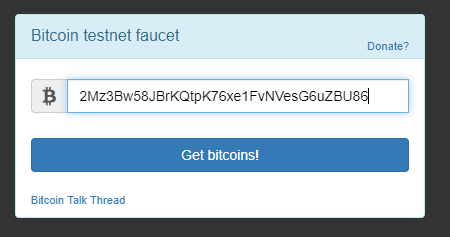

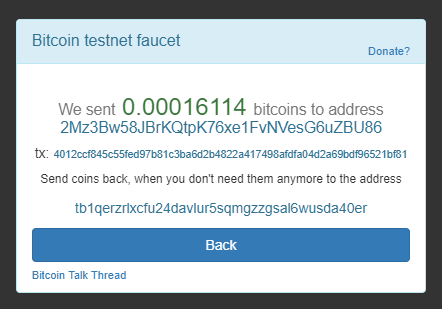

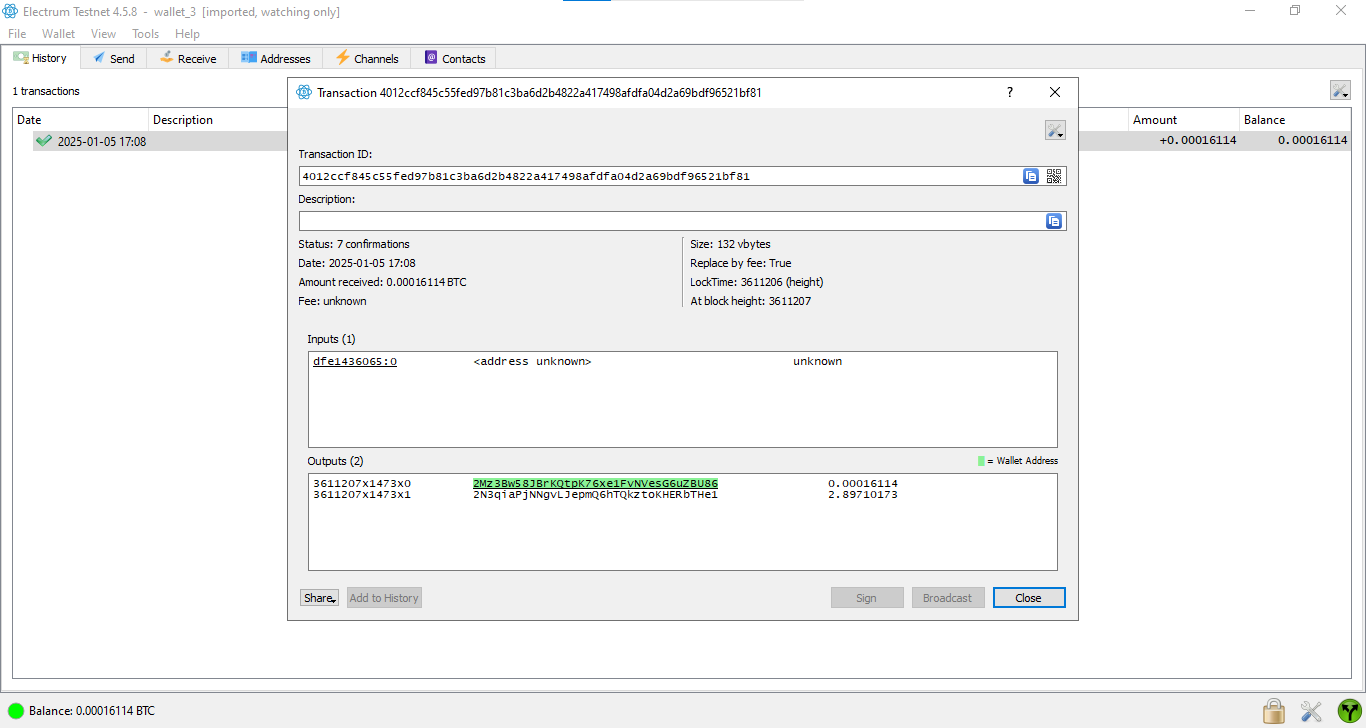

In [9]:
#Tạo ScriptPubKey để khóa quỹ
script_pubkey = scriptPubKey(redeem_script_sender)
print("ScriptPubKey:", script_pubkey)

ScriptPubKey: b'\xa9\x14J\x82,V\xe1\xbd\xde\xbfz\xbb\xdc\xa2\x08\x16\xe4\\f,B\x91\x87'


In [10]:
# Tạo các khóa riêng và khoá công khai cho người nhận
private_key1_receiver, private_key2_receiver, redeem_script_receiver, address_receiver = generate_keypair()
# In kết quả
print("Private Key 1:", private_key1_receiver)
print("Private Key 2:", private_key2_receiver)
print("Redeem Script:", redeem_script_receiver.hex())
print("Multisig Address:", address_receiver)


Private Key 1: cNkSmE3wL1J1TPnSM9wJkkNURXPd3yv6YC4kbNGXbRAfRfNbS8PZ
Private Key 2: cUCkLH1i6cBrAizQkpkHXSbZLW6ST197UG6h1ZuFD9tDgiheFF7a
Redeem Script: 522103844a01d2c7e791bce28cad0309a8cc2b98e2c329178088961ee7d7fd221dcc7c21036b420926d3a95ba43554e6b6d9b46fdf93da2063a2e9f86426dff698ae674b9b52ae
Multisig Address: 2NFzvndJQmBF9Rcm8eRSzjffs543Rb4C2xj


In [11]:
# Khởi tạo các tham số cho giao dịch
txid = input("Nhập TXID của UTXO : ")  # Transaction ID của giao dịch
output_index = int(input("Nhập output index : "))  # Index của UTXO
amount_to_send = int(float(input("Nhập số lượng BTC cần gửi : ")) * COIN)  # Chuyển BTC sang Satoshi

# Tạo giao dịch
tx = create_transaction([private_key1_sender, private_key2_sender], redeem_script_sender, address_receiver, txid, output_index, amount_to_send)

Nhập TXID của UTXO : 4012ccf845c55fed97b81c3ba6d2b4822a417498afdfa04d2a69bdf96521bf81
Nhập output index : 0
Nhập số lượng BTC cần gửi : 0.00015


In [ ]:
# Phát sóng giao dịch
broadcast_transaction(tx)

Lỗi API: RPC error
